## Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import transforms
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
parent_dir = Path.cwd().parent.parent.parent

"""
This code is used for Fig1.C. Spatial patterns of county-level charger density in 2014, 2019 and 2024.  
Data: (1) U.S. Boundaries, (2) U.S. EVSE location data
"""

'\nThis code is used for Fig1.C. Spatial patterns of county-level charger density in 2014, 2019 and 2024.  \nData: (1) U.S. Boundaries, (2) U.S. EVSE location data\n'

## Data Processing

In [2]:
def process_evse_data(year,parent_dir):
    """
    Processing EVSE and US boudary data, and performing spatial joining
    
    Parameters:
    -----------
    year : int
    usa_map_path : str or Path, optional
    
    Returns:
    --------
    joined_data : GeoDataFrame
    """

    # Read data
    usa_map_file = parent_dir / 'data' / 'US-map' /'usa_map.geojson'
    evse_file = parent_dir / 'data' /'US-EV-Station-2014-2024'/f'alt_fuel_stations_historical_day (Dec 31 {year}).geojson'
    print(f"Reading EVSE data of {year} ...")
    USA_map = gpd.read_file(usa_map_file)
    acc_data = gpd.read_file(evse_file)
    
    # same crs
    USA_map = USA_map.to_crs(epsg=4326)  # WGS84 
    acc_data = acc_data.to_crs(epsg=4326)
    
    # spatial joining
    print("Spatial joining...")
    joined_data = gpd.sjoin(acc_data, USA_map, how="inner", predicate="within")
    
    # Convert EVSE columns to numeric
    for col in ['ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num']:
        joined_data[col] = pd.to_numeric(joined_data[col], errors='coerce').fillna(0)
    
    # Calculate total EVSE count
    joined_data['total_EVSE'] = (joined_data['ev_level1_evse_num'] + 
                                joined_data['ev_level2_evse_num'] + 
                                joined_data['ev_dc_fast_num'])
    
    # Aggregate statistics by administrative region
    charging_station_stats = joined_data.groupby('index_right').agg(
        count=('total_EVSE', 'size'),      # Number of charging stations
        AC_EVSE=('ev_level2_evse_num', 'sum'),
        DC_EVSE=('ev_dc_fast_num', 'sum'),
        total_EVSE=('total_EVSE', 'sum')   # Total EVSE count
    ).reset_index()
    
    # Merge results back to original US map
    USA_map_with_count = USA_map.merge(
        charging_station_stats,
        left_index=True,
        right_on='index_right',
        how='left'
    )
    
    # Fill NaN values with 0 (regions with no charging stations)
    fill_cols = ['count', 'total_EVSE', 'AC_EVSE', 'DC_EVSE']
    for col in fill_cols:
        USA_map_with_count[col] = USA_map_with_count[col].fillna(0)
    
    # Print summary statistics
    print(f"Total EVSE: {USA_map_with_count['total_EVSE'].sum():,}")
    print(f"DC EVSE: {USA_map_with_count['DC_EVSE'].sum():,}")
    print(f"AC EVSE: {USA_map_with_count['AC_EVSE'].sum():,}")
    
    return USA_map_with_count,USA_map

## Calculating density of county-level EVSE

In [3]:
def calculate_density(evse_gdf):
    """
    Calculate EVSE density per square kilometer.
    
    Parameters:
    -----------
    evse_gdf : GeoDataFrame
        EVSE data with geometries and counts
    
    Returns:
    --------
    evse_gdf : GeoDataFrame
        Original data with added density columns
    """
    if evse_gdf.crs == 'EPSG:4326':
        # Convert to UTM for accurate area calculation
        evse_gdf = evse_gdf.to_crs(epsg=32614)
        
        # Calculate area in square meters and convert to square kilometers
        evse_gdf['area_km2'] = evse_gdf.geometry.area / 1e6
        
        # Calculate charging station density
        evse_gdf['cs_density'] = evse_gdf['total_EVSE'] / evse_gdf['area_km2']
    
    return evse_gdf

## Mapping and Visualization

In [4]:
def merge_state_geometries(usa_gdf):
    """
    Merge geometries by state name to create unified state boundaries.
    
    Parameters:
    -----------
    usa_gdf : GeoDataFrame
        US map data with state geometries
    
    Returns --> Merged state geometries with unified boundaries for visualization
    """
    merged_geometries = {}
    for state_name, group in usa_gdf.groupby('NAME_1'):
        # Merge multiple polygons into single geometry
        if len(group) > 1:
            merged_geom = unary_union(group['geometry'].tolist())
        else:
            merged_geom = group['geometry'].iloc[0]
        merged_geometries[state_name] = merged_geom
    
    # Create merged GeoDataFrame
    merged_gdf = gpd.GeoDataFrame(
        {'NAME_1': list(merged_geometries.keys()), 
         'geometry': list(merged_geometries.values())},
        geometry='geometry'
    ).set_crs(epsg=4326)
    
    return merged_gdf

In [5]:
def plot_evse_density_map(merged_states, result_with_density, target='US'):
    """
    Plot EVSE density map for specified US region.
    
    Parameters:
    -----------
    merged_states : GeoDataFrame
    result_with_density : GeoDataFrame
    target : str --> Target region: 'US' (mainland), 'HI' (Hawaii), or 'AK' (Alaska) 
    """
    
    # Define Albers Equal Area projection
    albers_proj = '+proj=aea +lat_1=20 +lat_2=60 +lon_0=0'
    
    # Define fonts
    font_settings = {
        'legend_font': {'family': 'Arial', 'weight': 'normal', 'size': 6},
        'title_font': {'family': 'Arial', 'style': 'italic', 'color': 'black', 'size': 6}
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    
    # Configure plot settings
    plt.rcParams['legend.labelspacing'] = 0.8
    plt.rcParams['legend.title_fontsize'] = 8
    
    # Apply rotation transformation
    base = ax.transData
    rotation = transforms.Affine2D().rotate_deg(60)
    transform = rotation + base
    
    # Plot state boundaries
    merged_states.to_crs(albers_proj).plot(
        ax=ax, aspect='equal', facecolor='none', 
        edgecolor='black', linewidth=0.2, alpha=0.5, 
        zorder=11, transform=transform
    )
    
    # Plot EVSE density
    result_with_density.to_crs(albers_proj).plot(
        ax=ax, column='cs_density', cmap='YlOrRd',
        missing_kwds={
            "color": "lightgray", "edgecolor": "white",
            "hatch": "///", "label": "No data available"
        },
        facecolor='lightgray', legend=False,
        scheme='UserDefined',
        classification_kwds={'bins': [1e-18, 0.01, 0.05, 0.8, 1.5]},
        alpha=0.99, edgecolor='black', linewidth=0.015,
        legend_kwds={
            'loc': 'lower right', 'title': 'EVSE Density (per km²)',
            'shadow': False, 'prop': font_settings['legend_font'], "fmt": "{:.2f}"
        },
        zorder=1, transform=transform
    )
    
    # Set region-specific view limits
    region_limits = {
        'US': {'xlim': (-12800000, -7300000), 'ylim': (-3600000, 0)},
        'HI': {'xlim': (-17000000, -15500000), 'ylim': (-2500000, -1000000)},
        'AK': {'xlim': (-15800000, -12000000), 'ylim': (450000, 3000000)}
    }
    
    if target in region_limits:
        ax.set_xlim(region_limits[target]['xlim'])
        ax.set_ylim(region_limits[target]['ylim'])
    
    # Remove axes
    ax.axis('off')
    
    # Add title
    region_names = {'US': 'Continental US', 'HI': 'Hawaii', 'AK': 'Alaska'}
    title = f"EVSE Density - {region_names.get(target, target)} (2024)"
    ax.set_title(title, fontdict=font_settings['title_font'], pad=20)
    
    plt.tight_layout()
    return fig, ax

# Test run 2024

Reading EVSE data of 2024 ...


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Spatial joining...
Total EVSE: 195,569.0
DC EVSE: 49,864.0
AC EVSE: 144,917.0

Density calculation completed:


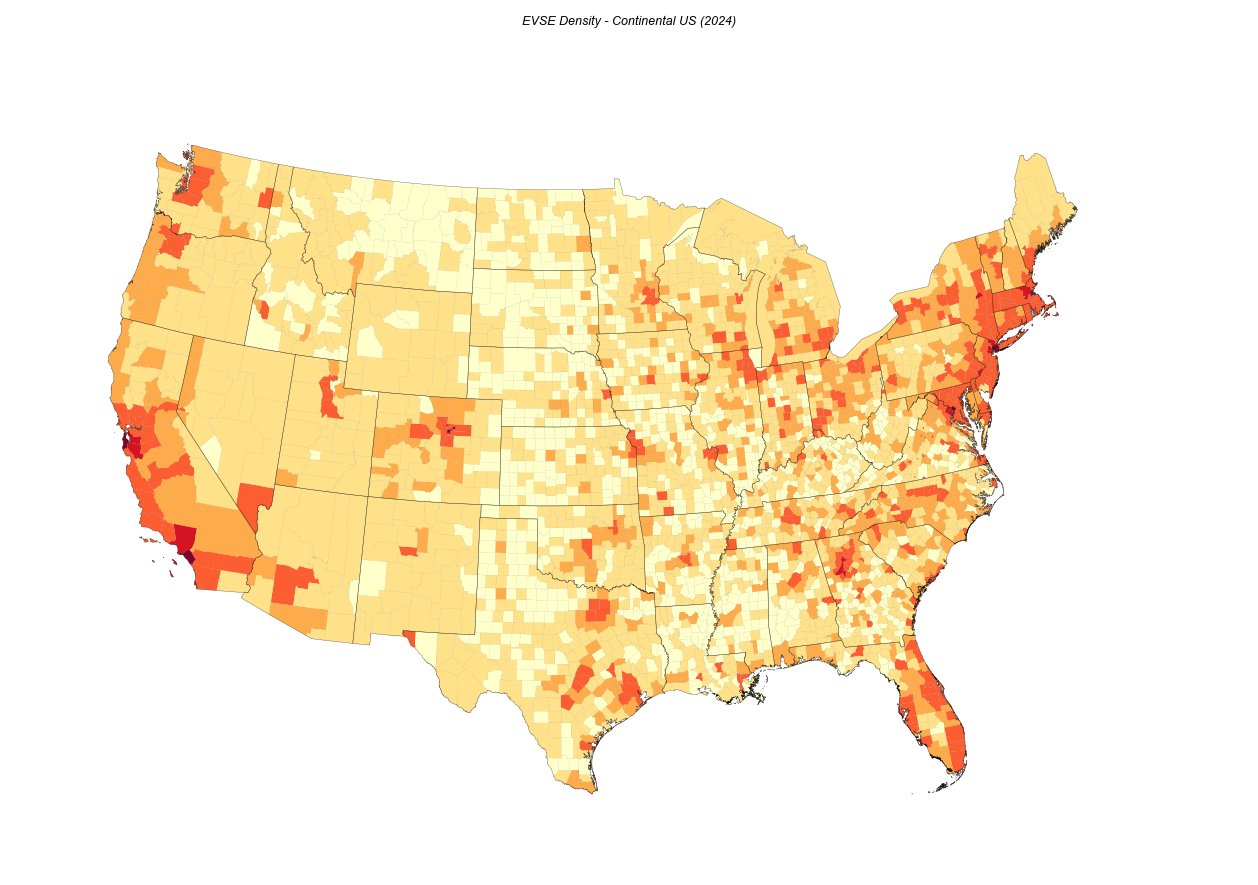

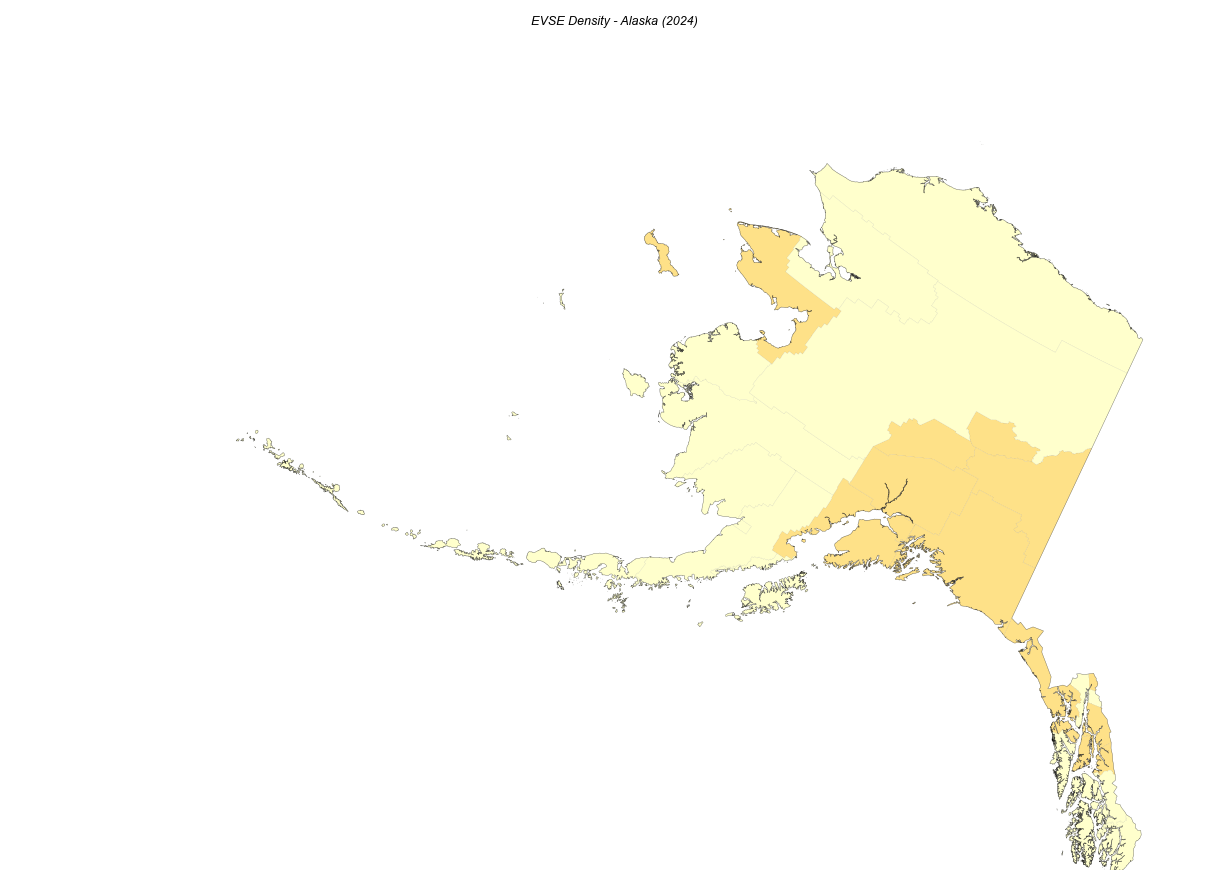

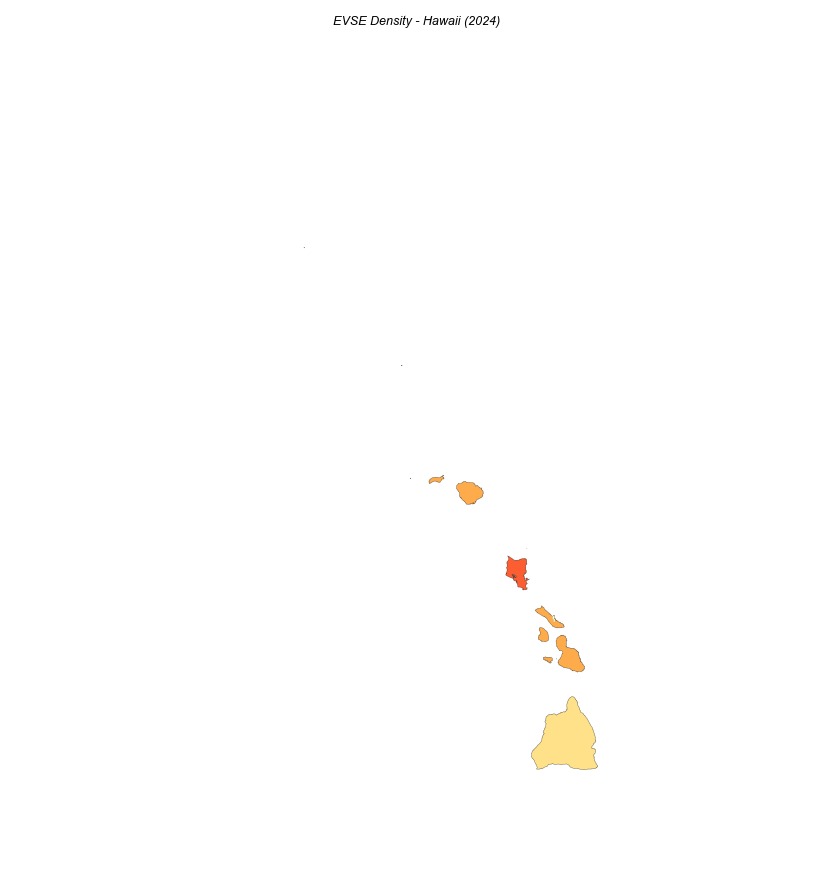

In [6]:
if __name__ == "__main__":
    
    # Step1: Data Processing
    #result_2014,USA_map = process_evse_data(2014,parent_dir) # you could change year here
    #result_2019,USA_map = process_evse_data(2019,parent_dir) # you could change year here
    result_2024,USA_map = process_evse_data(2024,parent_dir) # you could change year here
    
    # Step2: Calculate density
    result_2024_with_density = calculate_density(result_2024)
    print("\nDensity calculation completed:")
    
    # Step3: Merge state geometries
    merged_states = merge_state_geometries(USA_map)
    
    # Step4: Visualization
    fig1, ax1 = plot_evse_density_map(merged_states, result_2024_with_density, target='US')
    fig2, ax2 = plot_evse_density_map(merged_states, result_2024_with_density, target='AK')
    fig3, ax3 = plot_evse_density_map(merged_states, result_2024_with_density, target='HI')
    
    plt.show()